In [1]:
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import iris
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib import patheffects
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd
from pathlib import Path
import string
# My packages
import arke
# Local scripts
import mypaths
from horiz_cross import prepare_data
from plot_utils import plotter, map_kw, LCC_KW, AXGR_KW, mstart_kw, mfin_kw
import misc_utils as misc
from common_defs import fcst_strs, hours, pl_cases, um_res, toponyms

In [2]:
from tqdm import tqdm  # _notebook as tqdm

In [3]:
plt.style.use('./paperfig.mplstyle')

## Input data

In [4]:
level_dict = {'temp': {'value': 500.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
              'gh': {'value': 500.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
              'SSTmT': {'value': 500.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
#               'quiver': {'value': 500.0, 'unit': 'hPa', 'name': 'pressure', 'subdir': 'plev'},
              'seaice': {'name': '', 'subdir': 'sfc'}}
subdirs = {i['subdir'] for i in level_dict.values()}
varnames = [*level_dict.keys()]

In [5]:
run = 'ctrl'

In [6]:
list_of_cubelists = []
for fcst in tqdm(fcst_strs):
    _joint_cubelist = iris.cube.CubeList()
    for subdir in subdirs:
        input_path = str(mypaths.PATH_MASK).format(um_res=um_res,
                                                   fcst_init=fcst,
                                                   idir=run,
                                                   subdir=subdir)
        cubelist = iris.load(input_path,
                             callback=arke.io.clean_call)
        for cube in cubelist:
            add_attr = dict(subdir=subdir,
                            run=run,
                            um_res=um_res)
            cube.attributes.update(add_attr)
        _joint_cubelist += cubelist
    list_of_cubelists.append(_joint_cubelist)

100%|██████████| 2/2 [01:14<00:00, 37.21s/it]


In [7]:
vrbls2plot = dict()
for cubelist, (pl_case, fcst_str) in zip(list_of_cubelists, pl_cases.items()):
    vrbls2plot[fcst_str] = []
    for hour in hours[pl_case]:
        idt = datetime.strptime(fcst_str, '%Y%m%dT%H%MZ') + timedelta(hours=hour)
    
        vrbls2plot[fcst_str].append(prepare_data(cubelist, varnames,
                                                 idt, level_dict, {}))

In [8]:
mfc = '#FFFFFF'
mec = '#222222'

In [9]:
text_kw = dict(ha='center',
               path_effects=[patheffects.withStroke(linewidth=3,
                                                    foreground='w')])

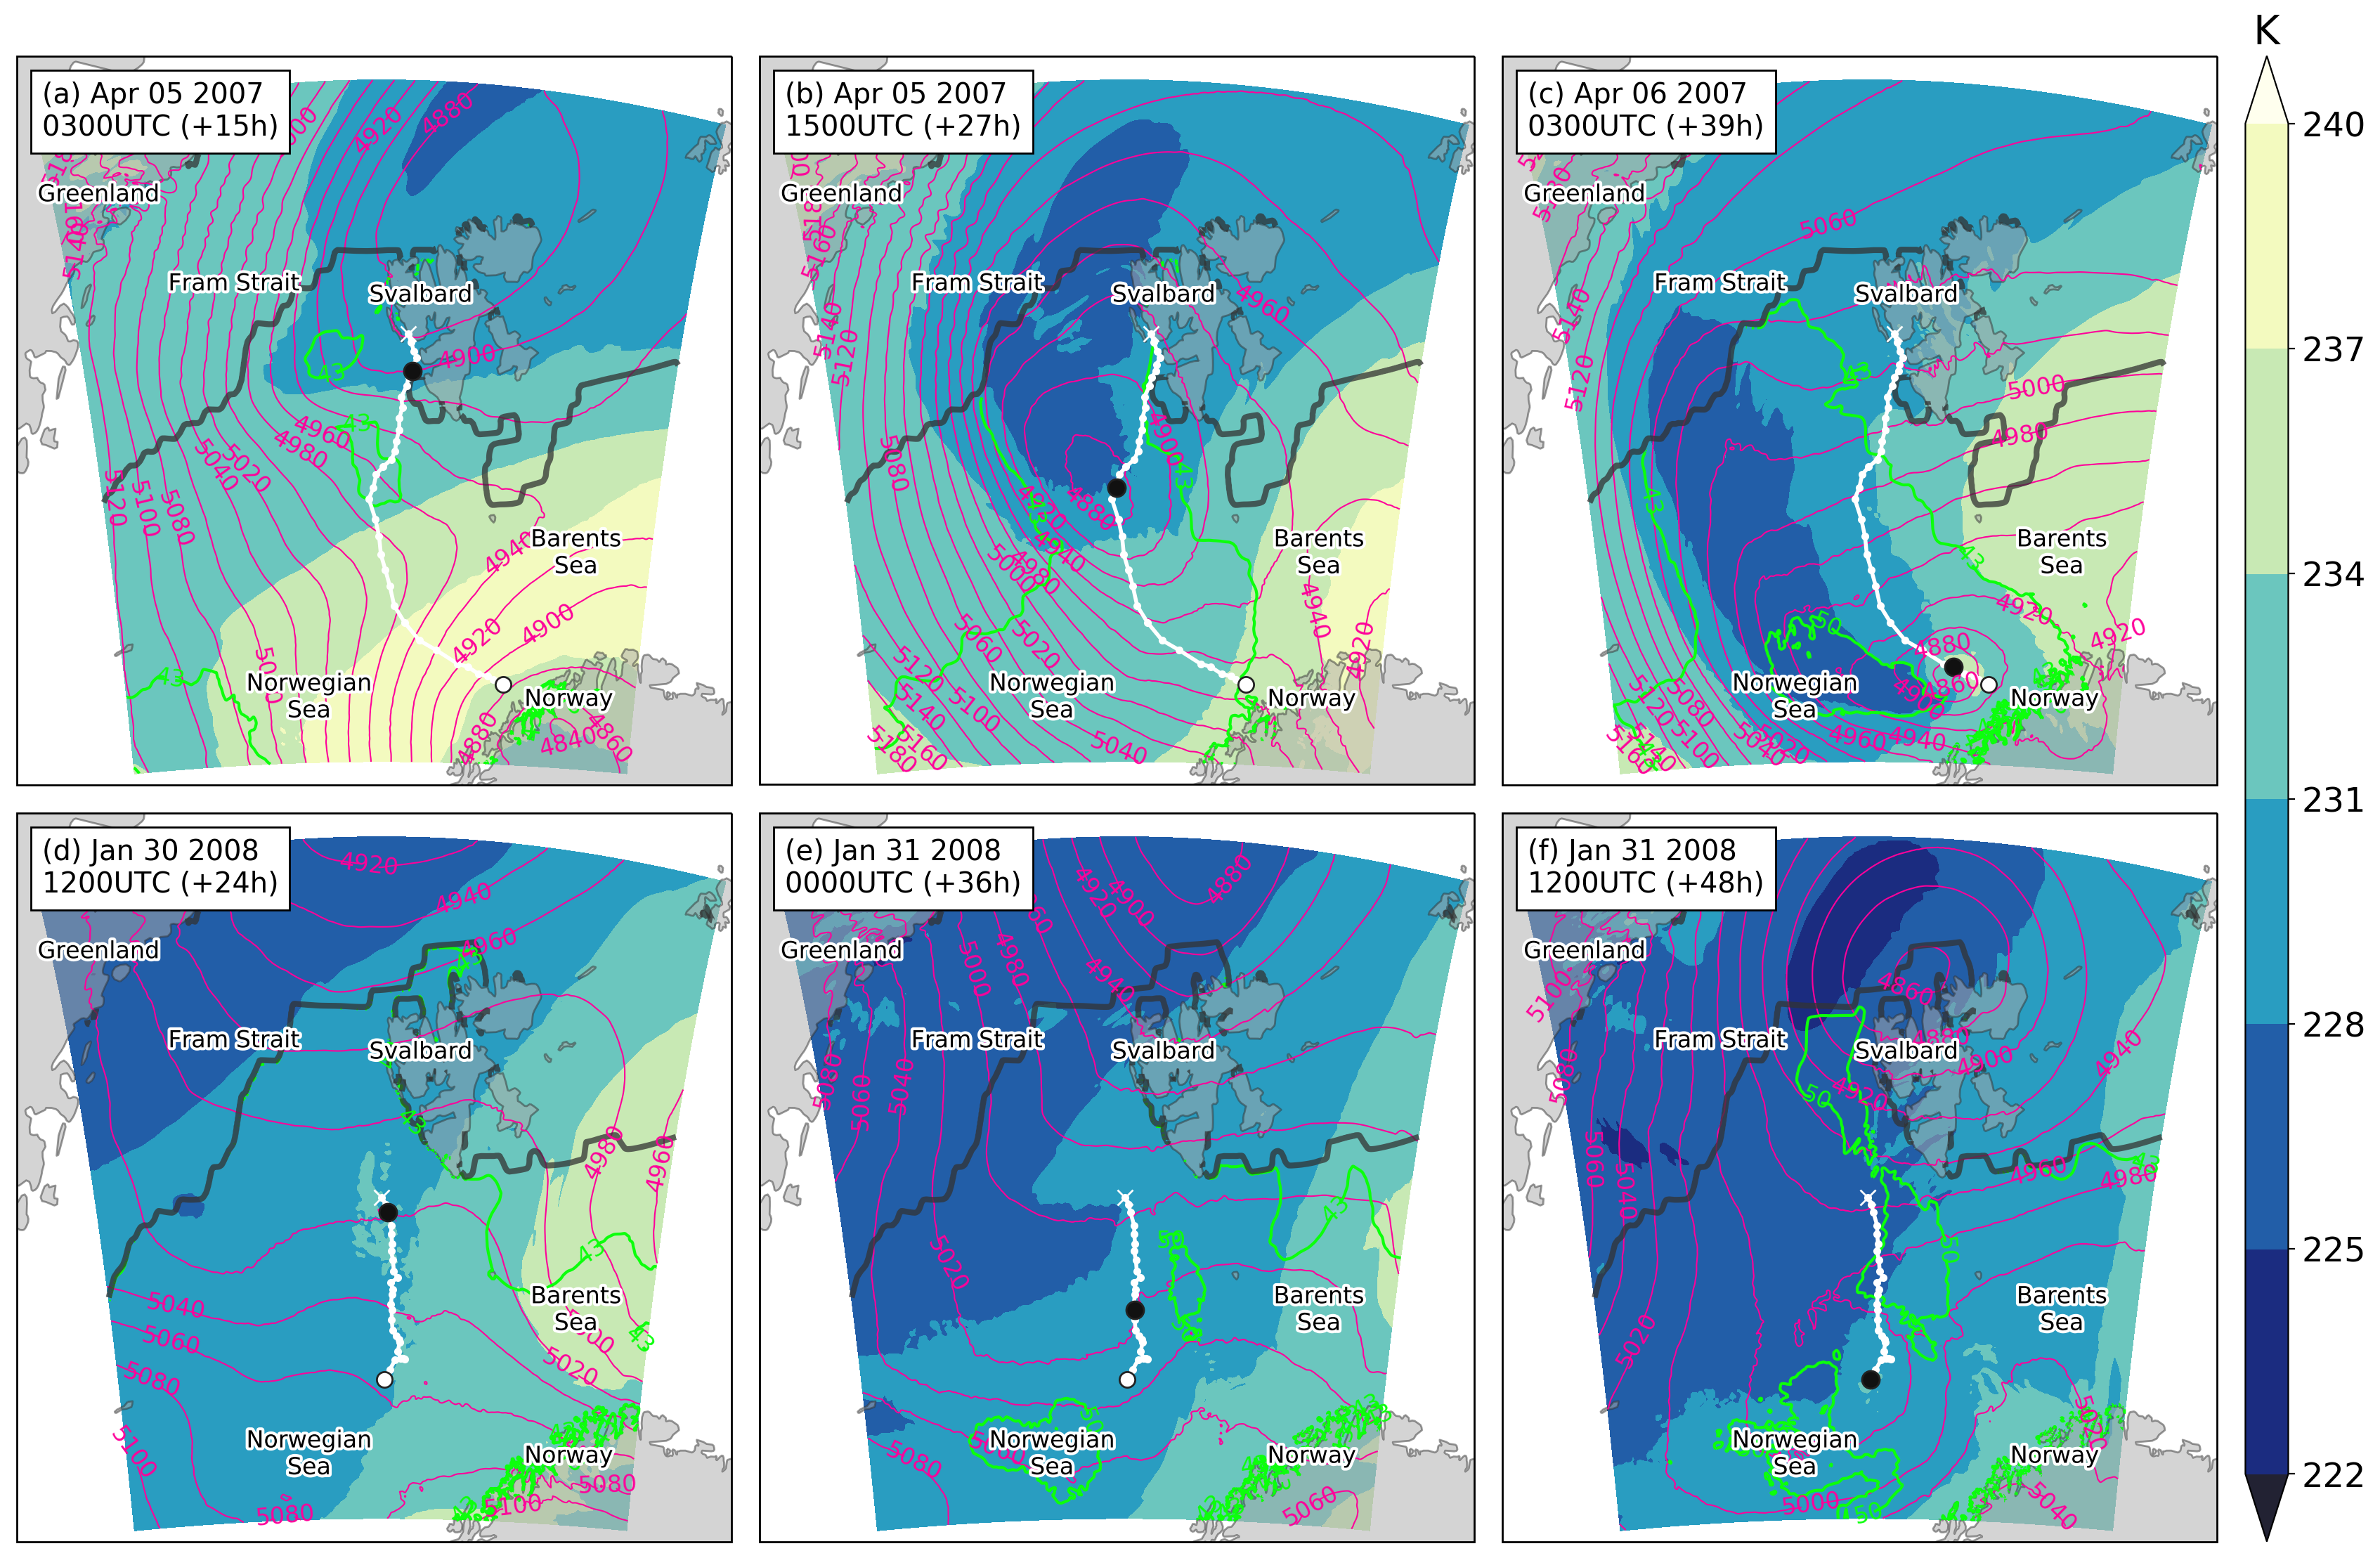

In [10]:
ncol = 3
nrow = len(pl_cases)
fig = plt.figure(figsize=(ncol*7, nrow*7))

axgr = arke.cart.lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

plotter(fig, axgr, map_kw, vrbls2plot, geoax=True)

vrbls = 'vort_mslp'
        
for count, (axrow, (pl_case, fcst_str)) in enumerate(zip(axgr.axes_row, pl_cases.items())):
    for nn, (ax, hour) in enumerate(zip(axrow, hours[pl_case])):
        input_dir = mypaths.trackdir / fcst_str / run
        tr_df = pd.read_csv(input_dir / f'pl_loc.{fcst_str}.{um_res}.{run}.{vrbls}.txt', parse_dates=[0])
        track_x, track_y = tr_df[['lon', 'lat']].values.T
            
        track_times = tr_df['time'].values.astype("<M8[ms]").astype(datetime)
        max_vort_dt = arke.coords.get_cube_datetimes(vrbls2plot[fcst_str][nn][0])[0]
        max_vort_x = np.asarray(track_x)[track_times == max_vort_dt][0]
        max_vort_y = np.asarray(track_y)[track_times == max_vort_dt][0]
        
        ax.plot(track_x, track_y, marker='o', ms=3, color=mfc, linewidth=2, **map_kw)
        ax.plot(track_x[0], track_y[0], mec=mfc, mfc=mfc, **mstart_kw, **map_kw)
        ax.plot(track_x[-1], track_y[-1], mec=mec, **mfin_kw, **map_kw)
        ax.plot(max_vort_x, max_vort_y, mec=mec, mfc='#111111', ms=9, marker='o', **map_kw)

for ax in axgr.axes_all:
    arke.cart.label_map(ax, toponyms, **map_kw, **text_kw)

In [11]:
fig.savefig(mypaths.plotdir / f'{run}_temp_gh_500hpa')